### Projeto Final de Spark
#### Campanha Nacional de Vacinação contra Covid-19

Autor: Arthur Freitas Gomes

Turma: Semantix Academy - Big Data Engineer 04-21

Professor: Rodrigo Rebouças

#### Enviar os dados para o hdfs

No terminal:

agomes:~/spark/input$ sudo mkdir desafio

agomes:~/spark/input/desafio$ sudo curl -O https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/04bd3419b22b9cc5c6efac2c6528100d_HIST_PAINEL_COVIDBR_06jul2021.rar

agome:~/spark/input/desafio$ sudo unrar x 04bd3419b22b9cc5c6efac2c6528100d_HIST_PAINEL_COVIDBR_06jul2021.rar

agomes:~/spark/input/desafio$ docker exec -it namenode bash

    root@namenode:/# hdfs dfs -mkdir -p /user/arthur/desafio
    root@namenode:/# hdfs dfs -put /input/desafio/* /user/arthur/desafio
    root@namenode:/# hdfs dfs -ls /user/arthur/desafio

In [548]:
!hdfs dfs -ls /user/arthur/desafio

Found 4 items
-rw-r--r--   3 root supergroup   62492959 2021-07-08 09:17 /user/arthur/desafio/HIST_PAINEL_COVIDBR_2020_Parte1_06jul2021.csv
-rw-r--r--   3 root supergroup   76520681 2021-07-08 09:17 /user/arthur/desafio/HIST_PAINEL_COVIDBR_2020_Parte2_06jul2021.csv
-rw-r--r--   3 root supergroup   91120916 2021-07-08 09:17 /user/arthur/desafio/HIST_PAINEL_COVIDBR_2021_Parte1_06jul2021.csv
-rw-r--r--   3 root supergroup    3046774 2021-07-08 09:17 /user/arthur/desafio/HIST_PAINEL_COVIDBR_2021_Parte2_06jul2021.csv


#### Otimizar todos os dados do hdfs para uma tabela Hive particionada por município

In [503]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [509]:
covid = spark.read.csv("/user/arthur/desafio/*.csv", header='true',sep=';')

In [517]:
#covid = covid.withColumnRenamed("interior/metropolitana", "interiorOUmetropolitana")

In [549]:
covid.write.mode("overwrite").saveAsTable('arthur.covid_otm', partitionBy="municipio")

In [557]:
!hdfs dfs -ls /user/hive/warehouse/arthur.db

Found 2 items
drwxr-xr-x   - root supergroup          0 2021-07-09 13:08 /user/hive/warehouse/arthur.db/covid_otm
drwxr-xr-x   - root supergroup          0 2021-07-09 12:57 /user/hive/warehouse/arthur.db/vs_01


#### Criando visualizações no Spark

In [82]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image

In [3]:
covid_otm = spark.read.table("arthur.covid_otm")

In [4]:
covid_otm.printSchema()

root
 |-- regiao: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- coduf: string (nullable = true)
 |-- codmun: string (nullable = true)
 |-- codRegiaoSaude: string (nullable = true)
 |-- nomeRegiaoSaude: string (nullable = true)
 |-- data: string (nullable = true)
 |-- semanaEpi: string (nullable = true)
 |-- populacaoTCU2019: string (nullable = true)
 |-- casosAcumulado: string (nullable = true)
 |-- casosNovos: string (nullable = true)
 |-- obitosAcumulado: string (nullable = true)
 |-- obitosNovos: string (nullable = true)
 |-- Recuperadosnovos: string (nullable = true)
 |-- emAcompanhamentoNovos: string (nullable = true)
 |-- interiorOUmetropolitana: string (nullable = true)
 |-- col_partition: integer (nullable = true)
 |-- municipio: string (nullable = true)



In [5]:
covid_otm = covid_otm.withColumn("Recuperadosnovos", col("Recuperadosnovos").cast(IntegerType()))
covid_otm = covid_otm.withColumn("emAcompanhamentoNovos", col("emAcompanhamentoNovos").cast(IntegerType()))
covid_otm = covid_otm.withColumn("casosAcumulado", col("casosAcumulado").cast(IntegerType()))
covid_otm = covid_otm.withColumn("casosNovos", col("casosNovos").cast(IntegerType()))
covid_otm = covid_otm.withColumn("populacaoTCU2019", col("populacaoTCU2019").cast(IntegerType()))
covid_otm = covid_otm.withColumn("obitosAcumulado", col("obitosAcumulado").cast(IntegerType()))
covid_otm = covid_otm.withColumn("obitosNovos", col("obitosNovos").cast(IntegerType()))

In [13]:
vis_01 = covid_otm.groupBy("regiao","data")\
        .agg(sum("Recuperadosnovos").alias("casos_recuperados"),\
             sum("emAcompanhamentoNovos").alias("em_acompanhamento")\
            ).sort(desc("data"))

In [15]:
vis_01.show(6)

+------------+----------+-----------------+-----------------+
|      regiao|      data|casos_recuperados|em_acompanhamento|
+------------+----------+-----------------+-----------------+
|Centro-Oeste|2021-07-06|             null|             null|
|       Norte|2021-07-06|             null|             null|
|    Nordeste|2021-07-06|             null|             null|
|     Sudeste|2021-07-06|             null|             null|
|         Sul|2021-07-06|             null|             null|
|      Brasil|2021-07-06|         17262646|          1065477|
+------------+----------+-----------------+-----------------+
only showing top 6 rows



In [16]:
vis_02 = covid_otm.groupBy("regiao","data")\
        .agg(sum("casosAcumulado").alias("casos_acumulados"),\
             sum("casosNovos").alias("casos_novos"),\
             sum("populacaoTCU2019").alias("populacao")
            ).sort(desc("data"))

vis_02 = vis_02.withColumn("incidencia",100000*col('casos_acumulados')/col('populacao'))
vis_02 = vis_02.drop('populacao')

In [19]:
vis_03 = covid_otm.groupBy("regiao","data")\
        .agg(sum("casosAcumulado").alias("casos_acumulados"),\
             sum("obitosAcumulado").alias("obitos_acumulados"),\
             sum("obitosNovos").alias("obitos_novos"),\
             sum("populacaoTCU2019").alias("populacao")
            ).sort(desc("data"))

vis_03 = vis_03.withColumn("letalidade", format_number(100*col('obitos_acumulados')/col('casos_acumulados'),2))
vis_03 = vis_03.withColumn("mortalidade", format_number(100000*col('obitos_acumulados')/col('populacao'),2))
vis_03 = vis_03.drop("casos_acumulados","populacao")

In [46]:
regiao = "Brasil"
last_day = "2021-07-06"

vis_01_loc = vis_01.filter(col("data")==last_day).filter(col("regiao")==regiao)
vis_02_loc = vis_02.filter(col("data")==last_day).filter(col("regiao")==regiao)
vis_03_loc = vis_03.filter(col("data")==last_day).filter(col("regiao")==regiao)

num_casos_rec = vis_01_loc.select("casos_recuperados").collect()[0][0]
num_casos_acomp = vis_01_loc.select("em_acompanhamento").collect()[0][0]

num_casos_acc = vis_02_loc.select("casos_acumulados").collect()[0][0]
num_casos_new = vis_02_loc.select("casos_novos").collect()[0][0]
inc_casos = vis_02_loc.select("incidencia").collect()[0][0]

num_obtos_acc = vis_03_loc.select("obitos_acumulados").collect()[0][0]
num_obtos_new = vis_03_loc.select("obitos_novos").collect()[0][0]
mortalidade = vis_03_loc.select("mortalidade").collect()[0][0]
letalidade = vis_03_loc.select("letalidade").collect()[0][0]

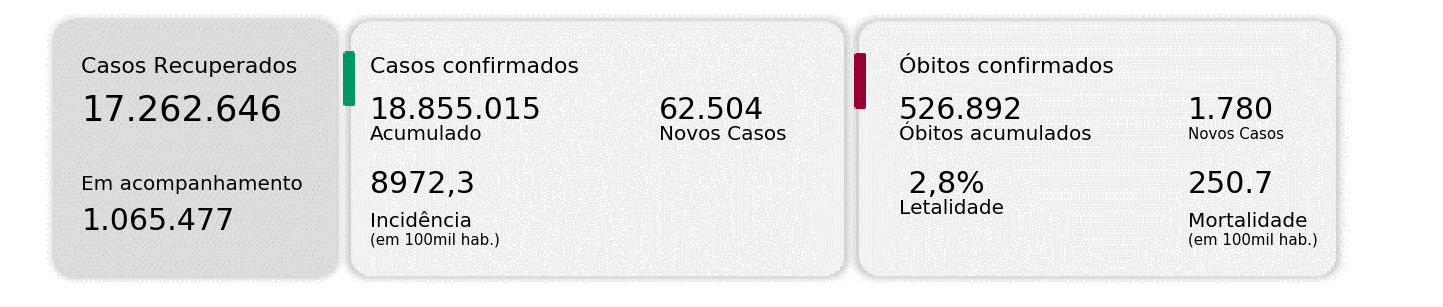

In [54]:
fig, axs = plt.subplots(figsize=(25,5))
gs = gridspec.GridSpec(ncols=5, nrows=2,figure=fig)

axs.axes.axis('off')

ax_back = fig.add_subplot(gs[0:2, 0:6])
img_back = Image.open('visual.png')
ax_back.imshow(img_back, aspect ='auto')
ax_back.axes.axis('off')
     
ax_1 = fig.add_subplot(gs[0, 0])
ax_1.axis('off')
ax_1.text(0.2, 0.55, "Casos Recuperados", ha="left", va="center", size=22)
ax_1.text(0.2, 0.20, "{0:_.0f}".format(num_casos_rec).replace("_","."), ha="left", va="center", size=35)

ax_2 = fig.add_subplot(gs[1, 0])
ax_2.axes.axis('off')
ax_2.text(0.2, 0.8, "Em acompanhamento", ha="left", va="center", size=20)
ax_2.text(0.2, 0.5, "{0:_.0f}".format(num_casos_acomp).replace("_","."), ha="left", va="center", size=30)

ax_3 = fig.add_subplot(gs[0, 1])
ax_3.axes.axis('off')
ax_3.text(0.2, 0.55, "Casos confirmados", ha="left", va="center", size=22)
ax_3.text(0.2, 0.2, "{0:_.0f}".format(num_casos_acc).replace("_","."), ha="left", va="center", size=30)
ax_3.text(0.2, 0.0, "Acumulado", ha="left", va="center", size=20)

ax_4 = fig.add_subplot(gs[0, 2])
ax_4.axes.axis('off')
ax_4.text(0.2, 0.2, "{0:_.0f}".format(num_casos_new).replace("_","."), ha="left", va="center", size=30)
ax_4.text(0.2, 0.0, "Novos Casos", ha="left", va="center", size=20)

ax_5 = fig.add_subplot(gs[1, 1])
ax_5.axes.axis('off')
ax_5.text(0.2, 0.8, "{0:4.1f}".format(inc_casos).replace(".",","), ha="left", va="center", size=30)
ax_5.text(0.2, 0.5, "Incidência", ha="left", va="center", size=20)
ax_5.text(0.2, 0.35, "(em 100mil hab.)", ha="left", va="center", size=15)

ax_6 = fig.add_subplot(gs[0, 3])
ax_6.axes.axis('off')
ax_6.text(0.0, 0.55, "Óbitos confirmados", ha="left", va="center", size=22)
ax_6.text(0.0, 0.2, "{0:_.0f}".format(num_obtos_acc).replace("_","."), ha="left", va="center", size=30)
ax_6.text(0.0, 0.0, "Óbitos acumulados", ha="left", va="center", size=20)

ax_7 = fig.add_subplot(gs[0, 4])
ax_7.axes.axis('off')
ax_7.text(0.0, 0.2, "{0:_.0f}".format(num_obtos_new).replace("_","."), ha="left", va="center", size=30)
ax_7.text(0.0, 0.0, "Novos Casos", ha="left", va="center", size=15)

ax_8 = fig.add_subplot(gs[1, 3])
ax_8.axes.axis('off')
ax_8.text(0.0, 0.8, "{0:4.1f}%".format(float(letalidade)).replace(".",","), ha="left", va="center", size=30)
ax_8.text(0.0, 0.6, "Letalidade", ha="left", va="center", size=20)

ax_9 = fig.add_subplot(gs[1, 4])
ax_9.axes.axis('off')
ax_9.text(0.0, 0.8, "{0:_.1f}".format(float(mortalidade)).replace("_","."), ha="left", va="center", size=30)
ax_9.text(0.0, 0.5, "Mortalidade", ha="left", va="center", size=20)
ax_9.text(0.0, 0.35, "(em 100mil hab.)", ha="left", va="center", size=15)

plt.show()

#### Salvar a primeira visualização como tabela Hive

In [55]:
vis_01.write.mode("overwrite").saveAsTable('arthur.vs_01')

In [57]:
!hdfs dfs -ls /user/hive/warehouse/arthur.db/vs_01

Found 201 items
-rw-r--r--   2 root supergroup          0 2021-07-09 14:06 /user/hive/warehouse/arthur.db/vs_01/_SUCCESS
-rw-r--r--   2 root supergroup       1331 2021-07-09 14:06 /user/hive/warehouse/arthur.db/vs_01/part-00000-cef8164f-c3ab-4f82-b86d-86cb5dc077b7-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1304 2021-07-09 14:06 /user/hive/warehouse/arthur.db/vs_01/part-00001-cef8164f-c3ab-4f82-b86d-86cb5dc077b7-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1329 2021-07-09 14:06 /user/hive/warehouse/arthur.db/vs_01/part-00002-cef8164f-c3ab-4f82-b86d-86cb5dc077b7-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1297 2021-07-09 14:06 /user/hive/warehouse/arthur.db/vs_01/part-00003-cef8164f-c3ab-4f82-b86d-86cb5dc077b7-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1331 2021-07-09 14:06 /user/hive/warehouse/arthur.db/vs_01/part-00004-cef8164f-c3ab-4f82-b86d-86cb5dc077b7-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1296 2021-07-09 14:06 

#### Salvar a segunda visualização com formato parquet e compressão snappy

In [58]:
vis_02.write.parquet("user/arthur/spark/desafio/vs_02", compression='snappy')

In [59]:
!hdfs dfs -ls user/arthur/spark/desafio/vs_02

Found 201 items
-rw-r--r--   2 root supergroup          0 2021-07-09 14:10 user/arthur/spark/desafio/vs_02/_SUCCESS
-rw-r--r--   2 root supergroup       1869 2021-07-09 14:10 user/arthur/spark/desafio/vs_02/part-00000-0f0e6817-f651-4141-9422-eff252091435-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1745 2021-07-09 14:10 user/arthur/spark/desafio/vs_02/part-00001-0f0e6817-f651-4141-9422-eff252091435-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1868 2021-07-09 14:10 user/arthur/spark/desafio/vs_02/part-00002-0f0e6817-f651-4141-9422-eff252091435-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1737 2021-07-09 14:10 user/arthur/spark/desafio/vs_02/part-00003-0f0e6817-f651-4141-9422-eff252091435-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1876 2021-07-09 14:10 user/arthur/spark/desafio/vs_02/part-00004-0f0e6817-f651-4141-9422-eff252091435-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1741 2021-07-09 14:10 user/arthur/spark/desafio/vs_0

-rw-r--r--   2 root supergroup       1736 2021-07-09 14:10 user/arthur/spark/desafio/vs_02/part-00178-0f0e6817-f651-4141-9422-eff252091435-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1853 2021-07-09 14:10 user/arthur/spark/desafio/vs_02/part-00179-0f0e6817-f651-4141-9422-eff252091435-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1729 2021-07-09 14:10 user/arthur/spark/desafio/vs_02/part-00180-0f0e6817-f651-4141-9422-eff252091435-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1856 2021-07-09 14:10 user/arthur/spark/desafio/vs_02/part-00181-0f0e6817-f651-4141-9422-eff252091435-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1736 2021-07-09 14:10 user/arthur/spark/desafio/vs_02/part-00182-0f0e6817-f651-4141-9422-eff252091435-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1853 2021-07-09 14:10 user/arthur/spark/desafio/vs_02/part-00183-0f0e6817-f651-4141-9422-eff252091435-c000.snappy.parquet
-rw-r--r--   2 root supergroup       1734 2021

####  Salvar a terceira visualização em um tópico no Kafka

In [68]:
vis_03.printSchema()

root
 |-- regiao: string (nullable = true)
 |-- data: string (nullable = true)
 |-- obitos_acumulados: long (nullable = true)
 |-- obitos_novos: long (nullable = true)
 |-- letalidade: string (nullable = true)
 |-- mortalidade: string (nullable = true)



In [85]:
vis_03_obt_acc = vis_03.select("regiao","data","obitos_acumulados")\
                       .withColumnRenamed("obitos_acumulados","value")\
                       .withColumn("value",col("value").cast(StringType()))

vis_03_obt_acc.write.format('kafka')\
              .option("kafka.bootstrap.servers","kafka:9092")\
              .option("topic","topic-vs-03-obt-acc")\
              .save()

In [87]:
vis_03_obt_new = vis_03.select("regiao","data","obitos_novos")\
                       .withColumnRenamed("obitos_novos","value")\
                       .withColumn("value",col("value").cast(StringType()))

vis_03_obt_new.write.format('kafka')\
              .option("kafka.bootstrap.servers","kafka:9092")\
              .option("topic","topic-vs-03-obt-new")\
              .save()

In [88]:
vis_03_letalid = vis_03.select("regiao","data","letalidade")\
                       .withColumnRenamed("letalidade","value")\
                       .withColumn("value",col("value").cast(StringType()))

vis_03_letalid.write.format('kafka')\
              .option("kafka.bootstrap.servers","kafka:9092")\
              .option("topic","topic-vs-03-letalid")\
              .save()

In [89]:
vis_03_mortalid = vis_03.select("regiao","data","mortalidade")\
                       .withColumnRenamed("mortalidade","value")\
                       .withColumn("value",col("value").cast(StringType()))

vis_03_mortalid.write.format('kafka')\
              .option("kafka.bootstrap.servers","kafka:9092")\
              .option("topic","topic-vs-03-mortalid")\
              .save()

No terminal

agomes:~/spark$ docker exec -it kafka bash

    bash-4.4# kafka-topics.sh --bootstrap-server kafka:9092 --list
    
    __consumer_offsets 
    topic-vs-03-letalid    
    topic-vs-03-mortalid    
    topic-vs-03-obt-acc    
    topic-vs-03-obt-new
